In [21]:
%load_ext autoreload
%autoreload 2

from core.data import *
from core.analysis import *
from core.visualization import *

import numpy as np
import scipy.signal as signal
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import linear_model
from time import time
import xgboost as xgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X, Y = load_x('data/x_train.h5'), load_y('data/y_train.csv')
# Split training and test data, 66 % of training data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33)

Started loading file data/x_train.h5
Finished loading the file.
Started loading file data/y_train.csv
Finished loading the file.


In [3]:
print('Shape of training data : ', X_train.shape, Y_train.shape)
print('Shape of testing data : ', X_test.shape, Y_test.shape)

# S'assurer du nombre de femmes (classe minoritaire) dans les deux ensembles
# y_train will be repeated 280 times
y_train0, y_test0 = np.argmax(Y_train, axis=1), np.argmax(Y_test, axis=1)
print('Ratio of women in training and test set : ', np.count_nonzero(y_train0) / float(len(y_train0)), np.count_nonzero(y_test0) / float(len(y_test0)))

Shape of training data :  (633, 40, 7, 500) (633, 2)
Shape of testing data :  (313, 40, 7, 500) (313, 2)
Ratio of women in training and test set :  0.21800947867298578 0.2268370607028754


In [4]:
sf = 250.0
duration = 0.5

In [5]:
def format_x(x):
    """
    Applatit aux maximum le x
    """
    N, C, H, W = x.shape
    return flatten_x(x).squeeze().reshape((N*C*H, W))

format_y = lambda y : np.argmax(flatten_y(y, repeat=280), axis=1)

def transformation(data):
    # bandwidth between 1 Hz and 20 Hz, with sampling freq. = 2.0
    # We want a high frequency resolution so we take a high window
    f, t, Zxx = signal.stft(data, fs=250.0, nperseg=250)
    f, Zxx = cut_frequency(Zxx, f, min_freq=1.0, max_freq=30.0)
    return Zxx.flatten()

In [6]:
x_train, x_test = format_x(X_train), format_x(X_test)
y_train, y_test = format_y(Y_train), format_y(Y_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(177240, 500) (87640, 500) (177240,) (87640,)


### 2 ) Utilisation de la methode de Welch pour comparer hommes et femmes

In [7]:
# Compute Welch PSD on all channels for all subjects

def welch_and_format(x, X):
    """
    Fait la methode de Welch sur chaque element de x de taille (N*C*H, W) et formate 
    comme X = (N, C, H, _) (derniere coordonnee est forcement changee)
    """
    # freq_numb = len(f)
    sf = 250.
    f = welch_method(x[0], sf)[0]
    trans = np.array([ welch_method(x[i], sf)[1] for i in range(len(x))])
    a, b, c, _ = X.shape
    return trans.reshape((a, b, c, len(f)))

In [8]:
debut = time()
trans = welch_and_format(x_train, X_train)
print('Elapsed time : ', time() - debut)
print(trans.shape)

Elapsed time :  41.27890682220459
(633, 40, 7, 129)


In [10]:
# We will have 14 plots in total : the mean PSD for each sensor, for mean and women
trans_men = np.array([trans[i] for i in range(len(trans)) if y_train0[i] == 0])
trans_women = np.array([trans[i] for i in range(len(trans)) if y_train0[i] == 1])

print('Repartition men / women : ', len(trans_men), len(trans_women))

Repartition men / women :  495 138


(495, 40, 7, 129) (138, 40, 7, 129)
(495, 7, 129) (138, 7, 129)
(7, 129) (7, 129)


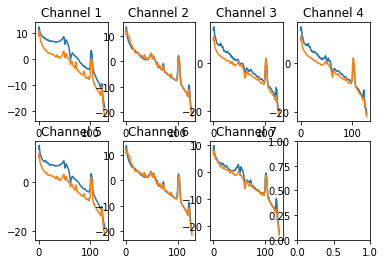

In [77]:
N_men, C, H, W2 = trans_men.shape
# old : mean_psd_men = np.mean(np.reshape(trans_men, (N_men*C, H, W2)), axis=0)

N_women, C, H, W2 = trans_women.shape 
# old : mean_psd_women = np.mean(np.reshape(trans_women, (N_women*C, H, W2)), axis=0)

print(trans_men.shape, trans_women.shape)

trans_men2 = np.mean(trans_men, axis=1)
trans_women2 = np.mean(trans_women, axis=1)

print(trans_men2.shape, trans_women2.shape)

mean_psd_men = np.mean(trans_men2, axis=0)
mean_psd_women = np.mean(trans_women2, axis=0)

print(mean_psd_men.shape, mean_psd_women.shape)

plot_eeg_samples([np.log(mean_psd_men), np.log(mean_psd_women)])

### 3 ) Testing classification abilities with Welch transform on log scale


In [83]:
psd_train0 = welch_and_format(x_train, X_train)
psd_test0  = welch_and_format(x_test, X_test)

In [94]:
# average over 40 samples. Input data for training ! 
psd_train = np.mean(psd_train0, axis=1)
psd_test =  np.mean(psd_test0, axis=1)

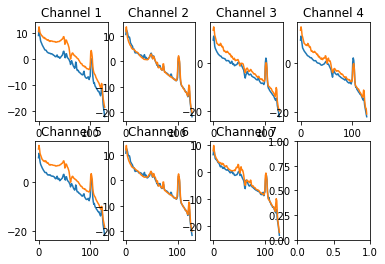

In [95]:
psd_women_train = np.mean(np.array([psd_train[i] for i in range(len(psd_train)) if y_train0[i] == 1]), axis=0)
psd_men_train   = np.mean(np.array([psd_train[i] for i in range(len(psd_train)) if y_train0[i] == 0]), axis=0)

plot_eeg_samples([np.log(psd_women_train), np.log(psd_men_train)])

# Methode 1 : utiliser XGBoost 

In [105]:
param = {'max_depth':1, 'eta':1., 'objective':'binary:logistic' }

clf7 = []

train_predictions = np.zeros((len(y_train0), 7))

# 7 different classifiers for each different sensor
for i in range(7):
    clf7.append(xgb.XGBClassifier(**param))
    bst = clf7[i].fit(psd_train[:, i, :], y_train0)
    predictions = clf7[i].predict(psd_train[:, i])
    
    y_pred = np.where(predictions >= 0.5, 1., 0.)
    train_predictions[:, i] = y_pred
    print('Accuracy for sensor ' + str(i+1) + ' :' , metrics.accuracy_score(y_train0, y_pred))

mean_predictions = np.mean(train_predictions, axis=1)
y_train_pred = np.where(mean_predictions >= 0.5, 1., 0.)
print('Accuracy on training when mean voting : ', metrics.accuracy_score(y_train0, y_train_pred))

clf_voting = xgb.XGBClassifier(**param)
clf_voting.fit(train_predictions, y_train0)

predict = clf_voting.predict(train_predictions)
y_train_pred2 = np.where(predict >= 0.5, 1., 0.)
print('Accuracy on training with XGB voting : ', metrics.accuracy_score(y_train0, y_train_pred2))

Accuracy for sensor 1 : 0.9399684044233807
Accuracy for sensor 2 : 0.9462875197472354
Accuracy for sensor 3 : 0.9383886255924171
Accuracy for sensor 4 : 0.9494470774091627
Accuracy for sensor 5 : 0.9399684044233807
Accuracy for sensor 6 : 0.9399684044233807
Accuracy for sensor 7 : 0.9462875197472354
Accuracy on training when mean voting :  0.9699842022116903
Accuracy on training with XGB voting :  0.9936808846761453


In [113]:
# 1 prediction per subject and per sensor
predictions = np.zeros(psd_test.shape[:2])
for i in range(7):
    predictions[:, i] = np.where(clf7[i].predict(psd_test[:, i]) >= 0.5, 1., 0.)

final_pred_test = clf_voting.predict(predictions)
y_pred_test = np.where(final_pred_test >= 0.5, 1., 0.)
print(metrics.accuracy_score(y_test0, y_pred_test), '&', metrics.f1_score(y_test0, y_pred_test))

# mean of predictions for each sensor 
mean_pred_test = np.mean(predictions, axis=1)
mean_y_pred_test = np.where(mean_pred_test >= 0.25, 1., 0.)
print(metrics.accuracy_score(y_test0, mean_y_pred_test), '&', metrics.f1_score(y_test0, mean_y_pred_test))

0.7635782747603834 & 0.24489795918367344
0.7476038338658147 & 0.30088495575221236


In [17]:
# Utilisation (par exemple) que du premier capteur
 
predict0 = np.where(clf7[0].predict(log_psd_test[:, 0]) >= 0.5, 1., 0.)
print('Accuracy on test set : ', metrics.accuracy_score(y_test0, predict0))

Accuracy on test set :  0.7252396166134185


In [20]:
X_val = load_x('data/x_test.h5')
x_val = format_x(X_val)

Started loading file data/x_test.h5
Finished loading the file.


In [23]:
psd_val = welch_and_format(x_val, X_val)

In [29]:
log_psd = np.mean(np.log(psd_val), axis=1)
predictions = np.zeros(log_psd.shape[:2])

for i in range(7):
    predictions[:, i] = np.where(clf7[i].predict(log_psd[:, i]) >= 0.5, 1., 0.)

final_pred = clf_voting.predict(predictions)
# Uncomment below to save predictions
# save_csv(final_pred, 'data/xgboost2.csv')

### Methode 2  Modele lineaire

In [98]:
lms = []

# keep only 50 first (useful) coordinates
# perks : prevents pb with - inf
fnb = 50
input_data = np.zeros(shape=psd_train.shape[:2] + (fnb,))
input_data = psd_train[:, :, :fnb]

swghts = samples_weights(y_train0)

print('Training. Accuracy & F1-Score : ')

for i in range(7):
    # for now, default parameters
    lms.append(linear_model.LogisticRegression(penalty='l1', max_iter=10000))
    lms[i].fit(input_data[:, i], y_train0)
    predictions = lms[i].predict(input_data[:, i])
    print(metrics.accuracy_score(y_train0, predictions), '&', metrics.f1_score(y_train0, predictions))

print('Testing ... ')

test_data = np.zeros(shape=psd_test.shape[:2] + (fnb,))
test_data = psd_test[:, :, :fnb]

for i in range(7):
    predictions = lms[i].predict(test_data[:, i])
    print(metrics.accuracy_score(y_test0, predictions))

Training. Accuracy & F1-Score : 
0.8009478672985783 & 0.2125
0.7977883096366508 & 0.2
0.7898894154818326 & 0.08275862068965517
0.7993680884676145 & 0.15894039735099338
0.8025276461295419 & 0.1935483870967742
0.8009478672985783 & 0.20253164556962025
0.7977883096366508 & 0.13513513513513511
Testing ... 
0.7412140575079872
0.7380191693290735
0.7635782747603834
0.7731629392971247
0.7476038338658147
0.7380191693290735
0.7763578274760383
